# 大綱

1. 將總體統計資料更新並存出與整理
2. 讀入最新的 Fred data 並進行整理與存出
3. 進行預測
    - a. 沒有Fred data的多組in-sample的預測
        - 係數 熱力圖
    - b. 一組out-sample的預測

# Definition of functions (Only for code description)
In this section, we state all functions used in implementing the main code.
1. `date_tf`: used to transform the date from 民國 to 西元.
2. `nrmlize`: used to standardize the data.
3. `response`: this function combines several functions loaded from `request`, `json` and `pandas` which are used to get the data from nstatdb (中華民國統計資訊網之總體統計資料庫).
4. `update`: used to update the monthly data from Federal Reserve Bank of St.Louis.
5. `prepare_missing` and `remove_outliers`: are rewritten based on the matlab code provided by [Michael W. McCracken](https://research.stlouisfed.org/econ/mccracken/fred-databases/), and are used to deal with missing values and outliers.
6. `forecast`: the main function of this project. This function is flexible enough to cover different in-sample choices and to provide the out-of-sample forecasts based on using factor augmented regression with Lasso.
7. `figu_3D` and `figu_heatmap`: are two functions used to generate three-dimensions histogram and heatmap figures using the slope coefficients obtained from `forecast` (when different in-sample data are used to monitor the dynamics of slope coefficients)

In [1]:
# 引入 pandas 套件，並使用 pd 為別名(其提供高效能、簡易使用的資料格式(Data Frame)，以達到快速操作及分析資料)
import pandas as pd 
# 引入 numpy 套件，並使用 np 為別名(其重點在於陣列的操作，其所有功能特色都建築在同質且多重維度的 ndarray（N-dimensional array）上)
import numpy as np 
# 做圖用
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False # 使坐標軸刻度表簽正常顯示正負號
import seaborn as sns; sns.set()
#作用是內嵌畫圖，省略掉plt.show()這一步，直接顯示圖像。如果不加這一句的話，我們在畫圖結束之後需要加上plt.show()才可以顯示圖像
%matplotlib inline

# os 負責程序和作業系統之間的交互，可以處理大部分的文件操作
import os 
#os.getcwd() # 可看到當前工作路徑
os.chdir('/home/kian/Dropbox/NTPU/RA_project/RA/Janice/經濟預測/code') # 更改當前工作到存放有要讀取之function的位置 (所有"\"要變"\\"才行)
from funs import *


In [29]:
# 資料儲存的路徑
today = date.today()
#result_path = r'C:\Users\ntpu_metrics\Dropbox\RA\Janice\經濟預測\data' 
#graph_path = r'C:\Users\ntpu_metrics\Dropbox\RA\Janice\經濟預測\graph'
#result_path = r'C:\Users\kian_\Dropbox\NTPU\RA_project\RA\Janice\經濟預測\data'
#graph_path = r'C:\Users\kian_\Dropbox\NTPU\RA_project\RA\Janice\經濟預測\graph'
result_path = '/home/kian/Dropbox/NTPU/RA_project/RA/Janice/經濟預測/data'
graph_path = '/home/kian/Dropbox/NTPU/RA_project/RA/Janice/經濟預測/graph'

# 1. 將總體統計資料更新並存出與整理
(中華民國統計資訊網:https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sys=100&funid=defjsp)

In [3]:
# 台灣總體統計資料之文件檔名稱
URL_txt = result_path+'/tw_URL.txt'
# 讀入已存有的 Taiwan data
tw_data =  pd.read_csv(result_path+'/taiwan_data.csv',index_col=0,parse_dates=True) #如果CSV文件中要設為index的日期字符串為標準格式，則可以直接透過parse_dates=True 確保正確解析日期成為DatetimeIndex
# 將現有 dataframe 帶入 function(tw_URL)，得到是否有較新的台灣資料的訊息並自動使用與存出較新資料
tw_data = tw_URL(tw_data,URL_txt,df_to_csv=[result_path]) 

# 從 dataframe 中，加以計算成實質進、出口之變數
r_im = tw_data['進出口貿易總值(一般貿易制度)_USD(百萬美元)-進口'] /tw_data['進口物價基本分類指數(按HS)(美元計價)_總指數']
r_ex = tw_data['進出口貿易總值(一般貿易制度)_USD(百萬美元)-出口']/tw_data['出口物價基本分類指數(按HS)(美元計價)_總指數']

X = tw_data.drop(['進出口貿易總值(一般貿易制度)_USD(百萬美元)-進口','進出口貿易總值(一般貿易制度)_USD(百萬美元)-出口'],axis=1) # 將台灣資料留下解釋變數的部分
# 以內插法處理 nan 值的部分
X = X.interpolate() 


err: ## 物價變數 ## 

err: # 基本物價:

https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sys=220&funid=A030101015&outmode=8&ym='+oldest_date+'&ymt='+latest_date+'&cycle=1&outkind=11&compmode=0&ratenm=%u7D71%u8A08%u503C&fldlst=010000000000000000000000000010000001000000000000000100000000010001000000001000000&compmode=0&

err: # 進口物價(美元):

https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sys=220&funid=A030301015&outmode=8&ym='+oldest_date+'&ymt='+latest_date+'&cycle=1&outkind=11&compmode=0&ratenm=%u7D71%u8A08%u503C&fldlst=10000000000000000000000000000000000000000000000000000000000000000000&compmode=0&

err: # 進口物價(台幣):

https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sys=220&funid=A030302015&outmode=8&ym='+oldest_date+'&ymt='+latest_date+'&cycle=1&outkind=11&compmode=0&ratenm=%u7D71%u8A08%u503C&fldlst=10000000000000000000000000000000000000000000000000000000000000000000&compmode=0&

err: # 出口物價(美元): 

https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sys=220&funid=A030401015&outmode=8&ym='

# 2.讀入最新的 Fred data 並進行整理與存出 
(https://research.stlouisfed.org/econ/mccracken/fred-databases/)

In [4]:
# 讀入已存有的 fred 資料
fred_data = pd.read_csv(result_path+'/fred_data.csv',index_col=0,parse_dates=True)

# 比較是否有新資料，並且作整理
fred_data = fred_newdata(fred_data,df_to_csv=[result_path]) 
# 內插法處理 nan 值的部分
fred_data = fred_data.interpolate()

Is there any data update: Yes


# 3. 進行預測
In this section, we detail the methodology that we are used to forecast the trade performance in Taiwan. More specifically, we consider the following factor augmented regression framework:
\begin{align*}
y_{t+h} = \mathbf{f}_t'\boldsymbol{\beta}+\mathrm{Dummy(month)}+\epsilon_{t+h},
\end{align*}
where $y_{t+h}$ denotes the monthly real import or real export calculated by $\mathrm{im}_t/p_{\mathrm{im}_t}$ ( $\mathrm{ex}_t/p_{\mathrm{ex}_t}$, it is also suggested by dividing by $p_{\mathrm{ex}_{t-1}}$), $\mathbf{f}_t$ denotes a $r\times 1$ vector which consists of $r$ latent factors (unobservable), and $\epsilon_{t+h}$ is the forecast errors. Note that we also consider two types of the target variables: level and growth rate which are supposed to have different statistical properties (non-stationarity and stationarity). In this paper, while the statistical inference is not our main interest, different types may result different forecast performance of the forecast of the growth of import or export. Therefore, two types of the data are used to construct the evaluations of the out-of-sample forecasts.

Since the latent factors are unobserved, we assume that these factors are linked to an observed data ($x_{it}$) via a factor structure,
\begin{align*}
x_{it} = \mathbf{f}_t'\boldsymbol{\gamma}_i+e_{it},
\end{align*}
where $\boldsymbol{\gamma}_i$ represents the factor loadings which provide different impacts on $x_{it}$ from the latent factor $\mathbf{f}_t$. In this paper, we consider two sets of $x_{it}$ including the local data and the data from the US. The latent factors can be obtained from using singular value decomposition of $\mathbf{X}=(\mathbf{x}_1,...,\mathbf{x}_T)'$  and $\mathbf{x}_t=(x_{1t},...,x_{Nt})'$ (***stationary transformation in the US data while the local data depend on the the type of the target variable***). The number of the factors in each data set is fixed at ten and the estimated coefficients are obtained based on least absolute shrinkage and selection operator (Lasso) which is used to identify the importance of the latent factors. The tuning parameter for the regularization is obtained from the cross-validation (`LassoCV`).

In the code, `X` and `X1` refer to the raw local data and normalized local data, and `fred_data` refers to the monthly data from the US. The corresponding estimated factors are `f` and `f2` respectively. Our empirical design covers two models with/without the monthly data from the US. The main reason is that we are interested in understanding the importance of the latent factor from the US. Accordingly, we construct the following two nested models:
\begin{align*}
\mathrm{model_1}&\quad y_{1,t+h} = \mathbf{f}_t'\boldsymbol{\beta}_1+\mathrm{Dummy(month)}+\epsilon_{1,t+h},\\
\mathrm{model_2}&\quad y_{2,t+h} = \mathbf{f}_t'\boldsymbol{\beta}_1+\mathbf{f}_{2t}'\boldsymbol{\beta}_2+\mathrm{Dummy(month)}+\epsilon_{2,t+h}.
\end{align*}
Note that when the target variable is measured in level data, we have an issue of different orders of integrated variables ($y_t$ and $\mathbf{f}_t$ are non-stationary, and $\mathbf{f}_{2t}$ is stationary). We need to be careful of the potential issues when lasso is implemented.


## a.沒有Fred data的多組in-sample的預測 _ 重點放在係數  

In [ ]:
t_process1 = datetime(2010,1,1)
t_process2 = datetime(2021,7,1)

pred_without_fred_ultigroup_insample = {}
# 預測目標為進口(im)
pred_without_fred_ultigroup_insample['coef_im'] = forecast(r_im,'level',X,t_process1,t_process2,12)[0]
pred_without_fred_ultigroup_insample['coef_im_gr'] = forecast(r_im,'growth rate',X,t_process1,t_process2,12)[0]
# 預測目標為出口(ex)
pred_without_fred_ultigroup_insample['coef_ex'] = forecast(r_ex,'level',X,t_process1,t_process2,12)[0]
pred_without_fred_ultigroup_insample['coef_ex_gr'] = forecast(r_ex,'growth rate',X,t_process1,t_process2,12)[0]

In [ ]:
# 儲存係數結果
np.savez(result_path+'/coef.npz',a=pred_without_fred_ultigroup_insample['coef_im'],b=pred_without_fred_ultigroup_insample['coef_im_gr'],c=pred_without_fred_ultigroup_insample['coef_ex'],d=pred_without_fred_ultigroup_insample['coef_ex_gr'])


In [ ]:
# 讀取係數結果
coef = np.load(result_path+'/coef.npz')
coef_im = coef['a']
coef_im_gr = coef['b']
coef_ex = coef['c']
coef_ex_gr = coef['d']

### a 熱力圖 

In [ ]:
# 熱力圖
# 預測目標為進口(im)       
figu_heatmap(coef_im,'coef_im',-50,50)
figu_heatmap(coef_im_gr,'coef_im_gr',-0.15,0.15)
# 預測目標為出口(ex)
figu_heatmap(coef_ex,'coef_ex',-50,50)
figu_heatmap(coef_ex_gr,'coef_ex_gr',-0.15,0.15)

## b. 進行"未來"預測

In [5]:
# 欲預測的起始時間<表單式填寫 預測期數(H)、年份(forecast_year)、月份(forecast_month)>
H = 12 
forecast_year ='2023'
forecast_month ='6'
forecast_from = datetime.strptime(forecast_year+'-'+forecast_month+'-1','%Y-%m-%d').date()

# 資料最後的時間
tw_data_last = tw_data.index[-1].date()
fred_data_last = fred_data.index[-1].date()
print('***the latest date of the data:***','\nX:',tw_data_last,'\nFred:',fred_data_last)

# 預測未來時，in_sample的時間終點，基於tw_data_last會大於fred_data_last的特性建立:
if forecast_from <= fred_data_last:  # 舉例:在2022/10/14當下，fred_data_last為8月，則forecast_from為8月時，in-sample需為7月
    t_process_f = forecast_from - rd(months=1)  # in-sample的最後一期時間，為預測起始期的前一期
    t_process_f_with_fred = forecast_from - rd(months=1)
elif (forecast_from > fred_data_last) & (
        forecast_from <= tw_data_last):  # (記得要括號，不然會出錯)輸入的欲預測時間forecast_from為9月，超出fred_data_last8月，則不管怎樣fred_data之in-sample都是fred_data_last8月
    t_process_f = forecast_from - rd(months=1)
    t_process_f_with_fred = fred_data_last  # in-sample 直接等於資料最後時間
else:  # 只會發生在輸入的欲預測時間，超出兩個data_last，則不管怎樣兩個in-sample都是fdata_last
    t_process_f = tw_data_last
    t_process_f_with_fred = fred_data_last

print('***the latest date of the In-sample data:***','\nwithout Fred:',t_process_f,'\nwith Fred:',t_process_f_with_fred)




***the latest date of the data:*** 
X: 2023-05-01 
Fred: 2023-04-01
***the latest date of the In-sample data:*** 
without Fred: 2023-05-01 
with Fred: 2023-04-01


In [6]:
# 預測目標為進口(im)
im_model = Get_Forecast(r_im,X,fred_data,t_process_f,t_process_f_with_fred,H)
# 預測目標為出口(ex)    
ex_model = Get_Forecast(r_ex,X,fred_data,t_process_f,t_process_f_with_fred,H)


## c. 重製前次預測結果

In [8]:
#設更早以前的時間點為in_sample的時間終點
t_process_f = datetime(2023,1,1)  
t_process_f_with_fred = datetime(2023,1,1) 
H = 12 # 設定要預測幾期的結果

# 預測目標為進口(im)
im_model_old = Get_Forecast(r_im,X,fred_data,t_process_f,t_process_f_with_fred,H)
# 預測目標為出口(ex)    
ex_model_old = Get_Forecast(r_ex,X,fred_data,t_process_f,t_process_f_with_fred,H)


In [14]:
# 欲另外繪圖之資料:

start_t = '2021-6-1' # 圖形橫軸起始時間

im_0 = im_model.forecasts['forecast_without_fred_f']['real'][start_t:]
im_1 = im_model.forecasts['forecast_without_fred_f']['forecast(level)_0'][-(H+1):]
im_2 = im_model.forecasts['forecast_without_fred_f']['forecast_0'][-(H+1):]
im_3 = im_model.forecasts['forecast_with_fred_f']['forecast(level)_0'][-(H+1):]
im_4 = im_model.forecasts['forecast_with_fred_f']['forecast_0'][-(H+1):]

ex_0 = ex_model.forecasts['forecast_without_fred_f']['real'][start_t:]
ex_1 = ex_model.forecasts['forecast_without_fred_f']['forecast(level)_0'][-(H+1):]
ex_2 = ex_model.forecasts['forecast_without_fred_f']['forecast_0'][-(H+1):]
ex_3 = ex_model.forecasts['forecast_with_fred_f']['forecast(level)_0'][-(H+1):]
ex_4 = ex_model.forecasts['forecast_with_fred_f']['forecast_0'][-(H+1):]

im_0_old = im_model_old.forecasts['forecast_without_fred_f']['real'][start_t:]
im_1_old = im_model_old.forecasts['forecast_without_fred_f']['forecast(level)_0'][-(H+1):]
im_2_old = im_model_old.forecasts['forecast_without_fred_f']['forecast_0'][-(H+1):]
im_3_old = im_model_old.forecasts['forecast_with_fred_f']['forecast(level)_0'][-(H+1):]
im_4_old = im_model_old.forecasts['forecast_with_fred_f']['forecast_0'][-(H+1):]

ex_0_old = ex_model_old.forecasts['forecast_without_fred_f']['real'][start_t:]
ex_1_old = ex_model_old.forecasts['forecast_without_fred_f']['forecast(level)_0'][-(H+1):]
ex_2_old = ex_model_old.forecasts['forecast_without_fred_f']['forecast_0'][-(H+1):]
ex_3_old = ex_model_old.forecasts['forecast_with_fred_f']['forecast(level)_0'][-(H+1):]
ex_4_old = ex_model_old.forecasts['forecast_with_fred_f']['forecast_0'][-(H+1):]

In [15]:
#修改 matplotlib 默認參數
plt.rcParams['axes.facecolor'] = 'white' # 為多個繪圖設定預設背景色
plt.rcParams['axes.edgecolor'] = 'black' # 為多個繪圖設定預設邊框色

/tmp/ipykernel_187297/3159583119.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax1.hlines(y=np.mean(im_0['2022-1-1':'2022-3-1']),xmin=pd.datetime(2022,1,1), xmax=pd.datetime(2022,3,1),linewidth=3)
/tmp/ipykernel_187297/3159583119.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax1.text(pd.datetime(2022,2,1),np.mean(im_0['2022-1-1':'2022-3-1'])+0.002,'%.2f%%' % (100 * np.mean(im_0['2022-1-1':'2022-3-1'])),ha='center', va='bottom',fontsize=18)
/tmp/ipykernel_187297/3159583119.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax1.hlines(y=np.mean(im_0['2022-4-1':'2022-6-1']),xmin=pd.datetime(2022,4,1), xmax=pd.datetime(2022,6,1),linewidth=3)
/tmp/ipykernel_187297/3159583119.py

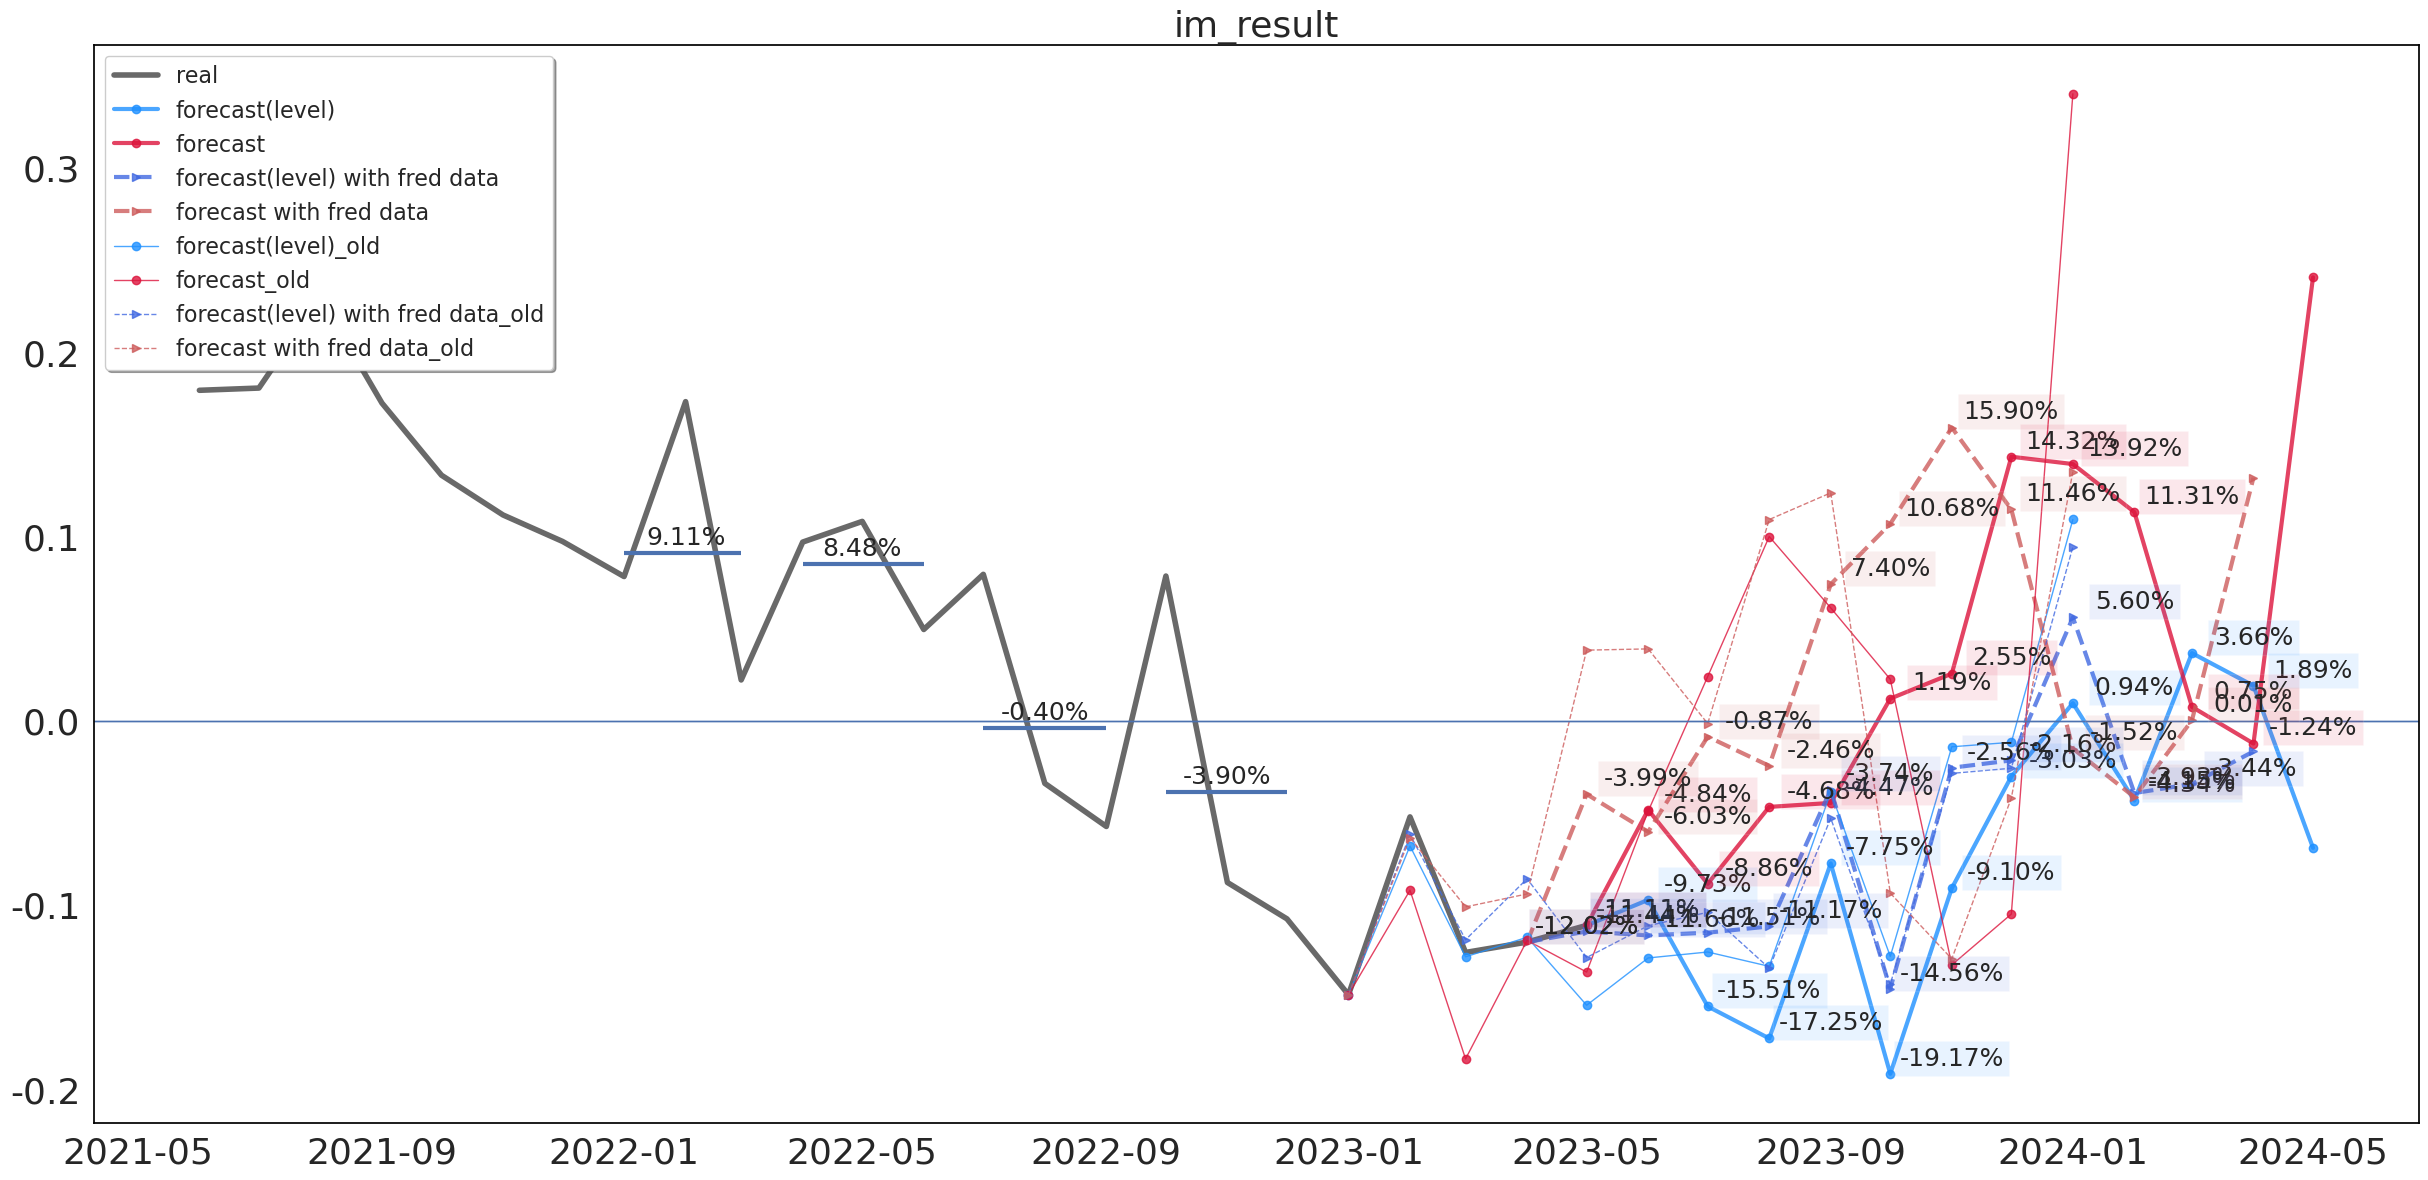

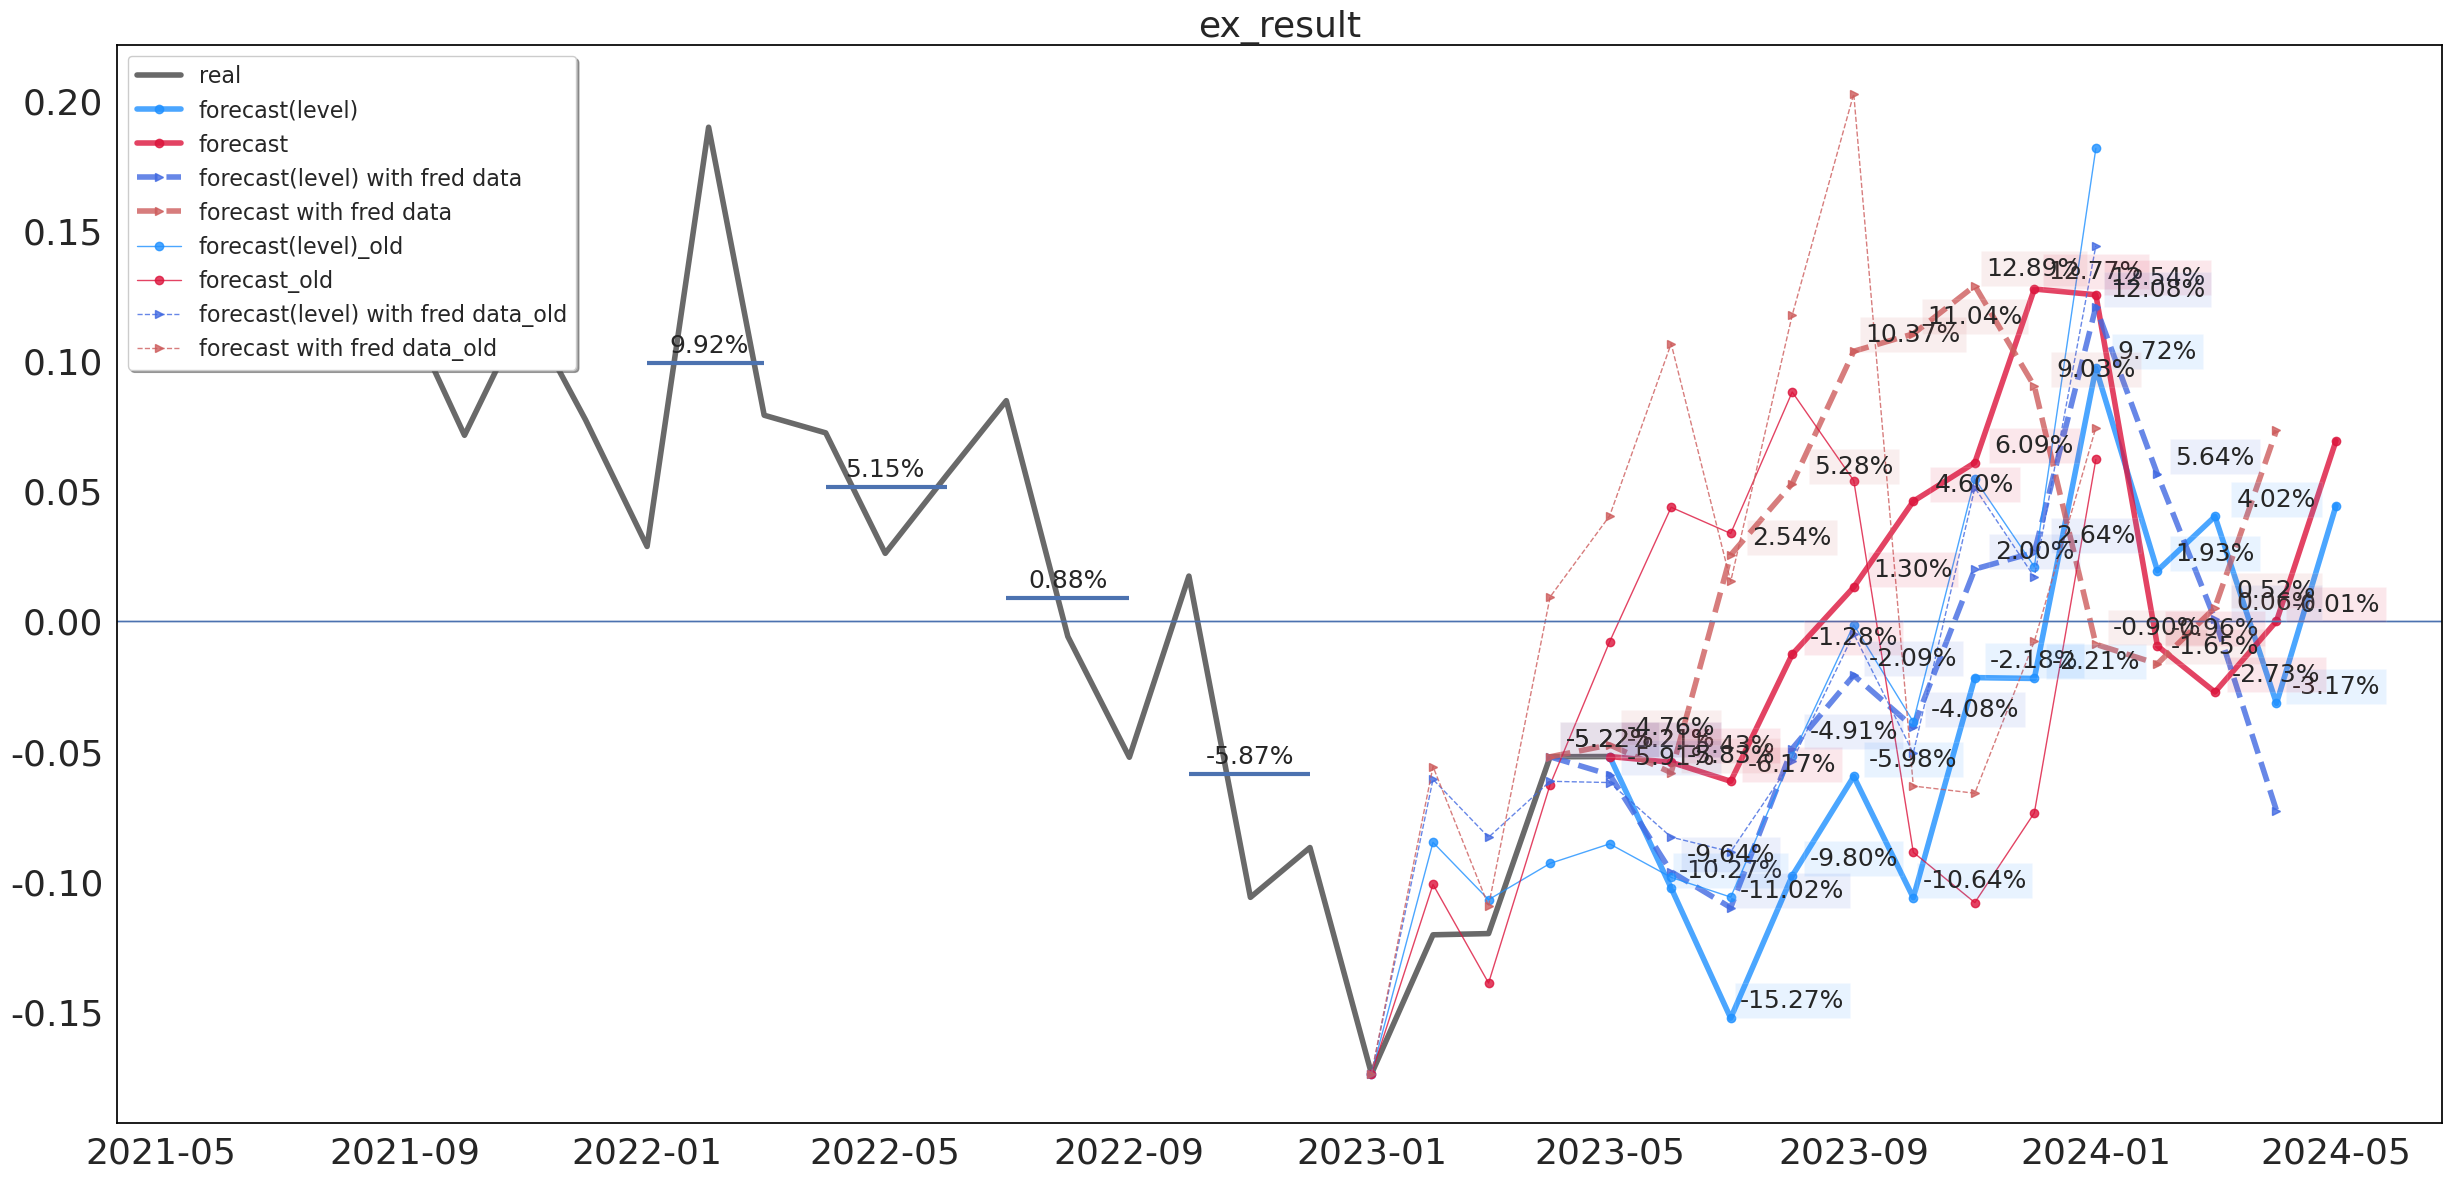

In [30]:
# 單純進口預測 <增加折點數值標籤 > 建立繪圖物件 fig, 大小為 30 * 10 ------------------
fig, ax1 = plt.subplots(figsize = (30, 14))
#plt.suptitle('Forecasts (IM)',fontsize=20)
# 設定小圖  (用 plot 繪圖、設定圖例、刻度)
ax1.set_title('im_result', fontsize=26)
ax1.plot(im_0, linewidth = 4, alpha=1, color='dimgray', label ='real' )
ax1.plot(im_1,marker='o', linewidth = 3, alpha=0.8, color='dodgerblue', label ='forecast(level)' )
ax1.plot(im_2,marker='o', linewidth = 3, alpha=0.8, color='crimson', label ='forecast' )
ax1.plot(im_3,marker='>', linewidth = 3, alpha=0.8, color='royalblue', linestyle = '--', label ='forecast(level) with fred data' )
ax1.plot(im_4,marker='>', linewidth = 3, alpha=0.8, color='indianred', linestyle = '--', label ='forecast with fred data' )

ax1.plot(im_1_old,marker='o', linewidth = 1, alpha=0.8, color='dodgerblue', label ='forecast(level)_old' )
ax1.plot(im_2_old,marker='o', linewidth = 1, alpha=0.8, color='crimson', label ='forecast_old' )
ax1.plot(im_3_old,marker='>', linewidth = 1, alpha=0.8, color='royalblue', linestyle = '--', label ='forecast(level) with fred data_old' )
ax1.plot(im_4_old,marker='>', linewidth = 1, alpha=0.8, color='indianred', linestyle = '--', label ='forecast with fred data_old' )

ax1.hlines(y=np.mean(im_0['2022-1-1':'2022-3-1']),xmin=pd.datetime(2022,1,1), xmax=pd.datetime(2022,3,1),linewidth=3)
ax1.text(pd.datetime(2022,2,1),np.mean(im_0['2022-1-1':'2022-3-1'])+0.002,'%.2f%%' % (100 * np.mean(im_0['2022-1-1':'2022-3-1'])),ha='center', va='bottom',fontsize=18)
ax1.hlines(y=np.mean(im_0['2022-4-1':'2022-6-1']),xmin=pd.datetime(2022,4,1), xmax=pd.datetime(2022,6,1),linewidth=3)
ax1.text(pd.datetime(2022,5,1),np.mean(im_0['2022-4-1':'2022-6-1'])+0.002,'%.2f%%' % (100 * np.mean(im_0['2022-4-1':'2022-6-1'])),ha='center', va='bottom',fontsize=18)
ax1.axhline(y=0,linewidth=1)
ax1.hlines(y=np.mean(im_0['2022-7-1':'2022-9-1']),xmin=pd.datetime(2022,7,1), xmax=pd.datetime(2022,9,1),linewidth=3)
ax1.text(pd.datetime(2022,8,1),np.mean(im_0['2022-7-1':'2022-9-1'])+0.002,'%.2f%%' % (100 * np.mean(im_0['2022-7-1':'2022-9-1'])),ha='center', va='bottom',fontsize=18)
ax1.hlines(y=np.mean(im_0['2022-10-1':'2022-12-1']),xmin=pd.datetime(2022,10,1), xmax=pd.datetime(2022,12,1),linewidth=3)
ax1.text(pd.datetime(2022,11,1),np.mean(im_0['2022-10-1':'2022-12-1'])+0.002,'%.2f%%' % (100 * np.mean(im_0['2022-10-1':'2022-12-1'])),ha='center', va='bottom',fontsize=18)
ax1.axhline(y=0,linewidth=1)
plt.setp(ax1.get_xticklabels(), fontsize=26)
#寫上折點的數值 (a b分別代表橫軸與眾軸)
for data,color in zip([im_1,im_2,im_3,im_4],['dodgerblue','crimson','royalblue','indianred']):
    for a,b in zip(data.index[-12:],data):
        ax1.text(a,b+0.002,'%.2f%%' % (100 * b),bbox=dict(facecolor='%s' %color, alpha=0.1),ha='center', va='bottom',fontsize=18)

ax1.legend(loc='upper left', shadow=True ,fontsize=16)
#ax1.set_yticks(np.linspace(-0.110,0.220,10))
plt.setp(ax1.get_yticklabels(), fontsize=26)
plt.grid(True) 

graph_path = os.path.join(graph_path, today.strftime('%Y%m'))
if os.path.exists(graph_path) == False:
    os.makedirs(graph_path)
plt.savefig(graph_path+'/Predicting the future values_im'+today.strftime('%b')+str(today.day)+'.png')

# 單純出口預測 <增加折點數值標籤 > 建立繪圖物件 fig, 大小為 30 * 10 ------------------
fig, ax2 = plt.subplots(figsize = (30, 14))
#plt.suptitle('Forecasts (EX)',fontsize=20)
# 設定小圖  (用 plot 繪圖、設定圖例、刻度)
ax2.set_title('ex_result', fontsize=26)
ax2.plot(ex_0, linewidth = 4, alpha=1, color='dimgray', label ='real' )
ax2.plot(ex_1,marker='o', linewidth = 4, alpha=0.8, color='dodgerblue', label ='forecast(level)' )
ax2.plot(ex_2,marker='o', linewidth = 4, alpha=0.8, color='crimson', label ='forecast' )
ax2.plot(ex_3,marker='>', linewidth = 4, alpha=0.8, color='royalblue', linestyle = '--', label ='forecast(level) with fred data' )
ax2.plot(ex_4,marker='>', linewidth = 4, alpha=0.8, color='indianred', linestyle = '--', label ='forecast with fred data' )

ax2.plot(ex_1_old,marker='o', linewidth = 1, alpha=0.8, color='dodgerblue', label ='forecast(level)_old' )
ax2.plot(ex_2_old,marker='o', linewidth = 1, alpha=0.8, color='crimson', label ='forecast_old' )
ax2.plot(ex_3_old,marker='>', linewidth = 1, alpha=0.8, color='royalblue', linestyle = '--', label ='forecast(level) with fred data_old' )
ax2.plot(ex_4_old,marker='>', linewidth = 1, alpha=0.8, color='indianred', linestyle = '--', label ='forecast with fred data_old' )


ax2.hlines(y=np.mean(ex_0['2022-1-1':'2022-3-1']),xmin=pd.datetime(2022,1,1), xmax=pd.datetime(2022,3,1),linewidth=3)
ax2.text(pd.datetime(2022,2,1),np.mean(ex_0['2022-1-1':'2022-3-1'])+0.002,'%.2f%%' % (100 * np.mean(ex_0['2022-1-1':'2022-3-1'])),ha='center', va='bottom',fontsize=18)
ax2.hlines(y=np.mean(ex_0['2022-4-1':'2022-6-1']),xmin=pd.datetime(2022,4,1), xmax=pd.datetime(2022,6,1),linewidth=3)
ax2.text(pd.datetime(2022,5,1),np.mean(ex_0['2022-4-1':'2022-6-1'])+0.002,'%.2f%%' % (100 * np.mean(ex_0['2022-4-1':'2022-6-1'])),ha='center', va='bottom',fontsize=18)
ax2.axhline(y=0,linewidth=1)
ax2.hlines(y=np.mean(ex_0['2022-7-1':'2022-9-1']),xmin=pd.datetime(2022,7,1), xmax=pd.datetime(2022,9,1),linewidth=3)
ax2.text(pd.datetime(2022,8,1),np.mean(ex_0['2022-7-1':'2022-9-1'])+0.002,'%.2f%%' % (100 * np.mean(ex_0['2022-7-1':'2022-9-1'])),ha='center', va='bottom',fontsize=18)
ax2.hlines(y=np.mean(ex_0['2022-10-1':'2022-12-1']),xmin=pd.datetime(2022,10,1), xmax=pd.datetime(2022,12,1),linewidth=3)
ax2.text(pd.datetime(2022,11,1),np.mean(ex_0['2022-10-1':'2022-12-1'])+0.002,'%.2f%%' % (100 * np.mean(ex_0['2022-10-1':'2022-12-1'])),ha='center', va='bottom',fontsize=18)
ax2.axhline(y=0,linewidth=1)
plt.setp(ax2.get_xticklabels(), fontsize=26)
#寫上折點的數值 (a b分別代表橫軸與眾軸)
for data,color in zip([ex_1,ex_2,ex_3,ex_4],['dodgerblue','crimson','royalblue','indianred']):
    for a,b in zip(data.index[-12:],data):
        ax2.text(a,b+0.002,'%.2f%%' % (100 * b),bbox=dict(facecolor='%s' %color, alpha=0.1),ha='center', va='bottom',fontsize=18)
ax2.legend(loc='upper left', shadow=True ,fontsize=16)
#ax2.set_yticks(np.linspace(-0.010,0.220,10))
plt.setp(ax2.get_yticklabels(), fontsize=26)
plt.grid(True) 

plt.savefig(graph_path+'/Predicting the future values_ex'+today.strftime('%b')+str(today.day)+'.png')

In [79]:
from sklearn.metrics import mean_squared_error as mse
t1 = myVars['im_'+str(np.argmin(np.array([mse(im_0['2023-1-1':'2023-5-1'],im_1_old['2023-1-1':'2023-5-1']),
mse(im_0['2023-1-1':'2023-5-1'],im_2_old['2023-1-1':'2023-5-1']),
mse(im_0['2023-1-1':'2023-5-1'],im_3_old['2023-1-1':'2023-5-1']),
mse(im_0['2023-1-1':'2023-5-1'],im_4_old['2023-1-1':'2023-5-1'])]))+1)].resample('Q').mean().apply(lambda x: format(x, '.2%'))
t2 = myVars['ex_'+str(np.argmin(np.array([mse(ex_0['2023-1-1':'2023-5-1'],ex_1_old['2023-1-1':'2023-5-1']),
mse(ex_0['2023-1-1':'2023-5-1'],ex_2_old['2023-1-1':'2023-5-1']),
mse(ex_0['2023-1-1':'2023-5-1'],ex_3_old['2023-1-1':'2023-5-1']),
mse(ex_0['2023-1-1':'2023-5-1'],ex_4_old['2023-1-1':'2023-5-1'])]))+1)].resample('Q').mean().apply(lambda x: format(x, '.2%'))

table = pd.concat([t1,t2],axis=1)
table.columns = ['Import','Export']

In [80]:
print(table.to_latex())

\begin{tabular}{lll}
\toprule
{} &   Import &  Export \\
\midrule
2023-06-30 &  -11.71\% &  -5.32\% \\
2023-09-30 &   -8.81\% &  -2.05\% \\
2023-12-31 &   -6.43\% &   7.82\% \\
2024-03-31 &   -0.59\% &   2.95\% \\
2024-06-30 &   -1.68\% &   3.46\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_187297/3293683267.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())
